In [1]:
!pip install -q transformers datasets sentencepiece accelerate evaluate sacrebleu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 3.1 MB/s eta 0:00:00


In [3]:
import os
import re
import html
import numpy as np
import pandas as pd

from datasets import Dataset

import evaluate
from transformers import (
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    DataCollatorForSeq2Seq,
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments,
)

os.environ["WANDB_DISABLED"] = "true"


In [4]:
from google.colab import files

print("Upload training_data_17.5k.xlsx, validation_data_7.5k.xlsx, testing_data_5k.xlsx")
uploaded = files.upload()


Upload training_data_17.5k.xlsx, validation_data_7.5k.xlsx, testing_data_5k.xlsx


Saving testing_data_5k.xlsx to testing_data_5k.xlsx
Saving training_data_17.5k.xlsx to training_data_17.5k.xlsx
Saving validation_data_7.5k.xlsx to validation_data_7.5k.xlsx


In [5]:
train_filename = "training_data_17.5k.xlsx"
val_filename   = "validation_data_7.5k.xlsx"
test_filename  = "testing_data_5k.xlsx"

assert train_filename in uploaded, "training_data_17.5k.xlsx not found in upload."
assert val_filename in uploaded, "validation_data_7.5k.xlsx not found in upload."
assert test_filename in uploaded, "testing_data_5k.xlsx not found in upload."


In [6]:
# Load dataframes
train_df = pd.read_excel(train_filename)
val_df   = pd.read_excel(val_filename)
test_df  = pd.read_excel(test_filename)

print("Train columns:", train_df.columns)
print("Val columns:", val_df.columns)
print("Test columns:", test_df.columns)

# Standardize column names
train_df = train_df.rename(columns={"Source": "en", "Translation": "hi"})
val_df   = val_df.rename(columns={"Source": "en", "Translation": "hi"})
test_df  = test_df.rename(columns={"Source": "en", "Translation": "hi"})

# --- Cleaning Function (NLLB-Safe) ---
def clean_text(s):
    """Convert to proper clean string; remove invisible unicode; strip whitespace."""
    if s is None:
        return ""
    if not isinstance(s, str):
        s = str(s)

    # HTML decode (&amp; → &)
    s = html.unescape(s)

    # Normalize Unicode invisible chars
    s = s.replace("\u200b", "")  # zero-width space
    s = s.replace("\xa0", " ")   # nonbreaking space
    s = s.replace("\ufeff", "")  # BOM

    # Remove newlines, extra spaces
    s = s.replace("\n", " ").strip()

    return s

# --- Apply cleaning + remove bad rows ---
for df_ in [train_df, val_df, test_df]:
    df_["en"] = df_["en"].map(clean_text)
    df_["hi"] = df_["hi"].map(clean_text)

    # Replace blank/whitespace-only strings with NaN
    df_.replace({"": np.nan, " ": np.nan}, inplace=True)

    # Remove rows where en/hi becomes nan or empty
    df_["en"] = df_["en"].replace(r'^\s*$', np.nan, regex=True)
    df_["hi"] = df_["hi"].replace(r'^\s*$', np.nan, regex=True)

    # Remove literal "nan" or "none"
    df_["en"] = df_["en"].replace({"nan": np.nan, "None": np.nan, "none": np.nan})
    df_["hi"] = df_["hi"].replace({"nan": np.nan, "None": np.nan, "none": np.nan})

    df_.dropna(subset=["en", "hi"], inplace=True)
    df_.reset_index(drop=True, inplace=True)

print("Cleaned Train size:", len(train_df))
print("Cleaned Val size:", len(val_df))
print("Cleaned Test size:", len(test_df))

train_df.head()

Train columns: Index(['Source', 'Translation'], dtype='object')
Val columns: Index(['Source', 'Translation'], dtype='object')
Test columns: Index(['Source', 'Translation'], dtype='object')
Cleaned Train size: 17500
Cleaned Val size: 7500
Cleaned Test size: 5000


,en,hi
0,3- The matter has been referred to the Full Be...,3 - मामला इससे संबंधित प्रश्न पर पूर्ण पीठ को ...
1,"4- In Reeta Mishra & Ors. vs. Director , Eleme...","4 - रीता मिश्रा एवं अन्य बनाम निदेशक , प्राथमि..."
2,"it is not in order to assert a legal right , b...",यह किसी वैधानिक अधिकार को सिद्ध करने के लिए नह...
3,a writ of mandamus can truly be claimed in the...,"किसी वैधानिक सार्वजनिक दायित्व के स्पष्ट , सीम..."
4,"it is not to be granted where , in fact , befo...",इसे तब प्रदान नहीं किया जाना है जहां इसे परिवर...


In [7]:
from datasets import Dataset

train_ds = Dataset.from_pandas(train_df)
val_ds   = Dataset.from_pandas(val_df)
test_ds  = Dataset.from_pandas(test_df)

train_ds, val_ds, test_ds

(Dataset({
     features: ['en', 'hi'],
     num_rows: 17500
 }),
 Dataset({
     features: ['en', 'hi'],
     num_rows: 7500
 }),
 Dataset({
     features: ['en', 'hi'],
     num_rows: 5000
 }))

In [8]:
model_name = "Helsinki-NLP/opus-mt-en-hi"  # you can change this later if needed

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/44.0 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

source.spm:   0%|          | 0.00/812k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/1.07M [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


pytorch_model.bin:   0%|          | 0.00/306M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

In [9]:
max_source_length = 256
max_target_length = 256

def preprocess_function(examples):
    inputs = examples["en"]
    targets = examples["hi"]

    # Tokenize source (English)
    model_inputs = tokenizer(
        inputs,
        max_length=max_source_length,
        truncation=True,
    )

    # Tokenize target (Hindi)
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            targets,
            max_length=max_target_length,
            truncation=True,
        )

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs


In [10]:
tokenized_train = train_ds.map(
    preprocess_function,
    batched=True,
    remove_columns=train_ds.column_names,
)

tokenized_val = val_ds.map(
    preprocess_function,
    batched=True,
    remove_columns=val_ds.column_names,
)

tokenized_test = test_ds.map(
    preprocess_function,
    batched=True,
    remove_columns=test_ds.column_names,
)

tokenized_train[0]


Map:   0%|          | 0/17500 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:4034: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/7500 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

{'input_ids': [614,
  69,
  81,
  1198,
  120,
  203,
  5979,
  7,
  4,
  4455,
  10035,
  3826,
  68,
  4,
  1862,
  79,
  7,
  847,
  19,
  35587,
  8,
  259,
  7049,
  28723,
  134,
  42,
  10779,
  7,
  17988,
  4072,
  376,
  3,
  1537,
  34,
  11251,
  4,
  29911,
  37805,
  3666,
  673,
  15386,
  137,
  50,
  4,
  17354,
  8455,
  807,
  4,
  1320,
  44,
  3,
  0],
 'attention_mask': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1],
 'labels': [614,
  32,
  4670,
  510,
  6077,
  4563,
  33,
  1174,
  3556,
  18,
  1698,
  57,
  139,
  115,
  5,
  25,
  2114,
  6,
  3132,
  6206,
  33901,
  2899,
  24,
  13860,
  4324,
  991,
  6833,
  716,
  15249,
  25132,
  18,
  6763,
  6,
  39,
  53650,
  53963,
  130,
  877,
  332,
  18,
  6437,
  579,
  1299,
  33,
  4807,
  11455,

In [11]:
pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=3af73dd584b3ada0920d4e1be29f3799b98d1809310eeccdecba855d502746f1
  Stored in directory: /root/.cache/pip/wheels/85/9d/af/01feefbe7d55ef5468796f0c68225b6788e85d9d0a281e7a70
Successfully built rouge_score


In [12]:
bleu_metric  = evaluate.load("sacrebleu")
rouge_metric = evaluate.load("rouge")
chrf_metric  = evaluate.load("chrf")

def postprocess_text(preds, labels):
    preds = [p.strip() for p in preds]
    labels = [l.strip() for l in labels]
    return preds, labels

def compute_metrics(eval_pred):
    preds, labels = eval_pred

    # When using predict_with_generate=True, preds are token IDs already
    # Replace -100 in labels (ignored) with pad_token_id for decoding
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)

    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)

    # sacrebleu expects list of hypotheses, list of list of references
    bleu = bleu_metric.compute(predictions=decoded_preds,
                               references=[[l] for l in decoded_labels])["score"]

    rouge = rouge_metric.compute(predictions=decoded_preds,
                                 references=decoded_labels,
                                 use_stemmer=True)
    chrf = chrf_metric.compute(predictions=decoded_preds,
                               references=decoded_labels)["score"]

    result = {
        "bleu": bleu,
        "rougeL": rouge["rougeL"],
        "chrf": chrf,
    }

    return result


In [13]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

import os
os.environ["WANDB_DISABLED"] = "true"

batch_size = 8

training_args = Seq2SeqTrainingArguments(
    output_dir="legal_mt_en_hi",
    eval_strategy="steps",
    eval_steps=500,              # eval every 500 steps
    save_strategy="no",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    num_train_epochs=100,        # large, we'll cap with max_steps
    max_steps=1000,              # 👈 HARD CAP on steps (change this to 600/800/etc.)
    predict_with_generate=True,
    fp16=True,
    logging_dir="logs",
    logging_steps=100,
    report_to="none",
)


In [14]:
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)


/tmp/ipython-input-4048247955.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


In [15]:
trainer.train()


The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None}.


Step,Training Loss,Validation Loss,Bleu,Rougel,Chrf
500,2.090000,2.026198,32.581242,0.413823,52.507492
1000,1.873900,1.888652,35.292451,0.428496,55.192951


TrainOutput(global_step=1000, training_loss=2.20534521484375, metrics={'train_runtime': 1992.513, 'train_samples_per_second': 4.015, 'train_steps_per_second': 0.502, 'total_flos': 147250259951616.0, 'train_loss': 2.20534521484375, 'epoch': 0.4570383912248629})

In [16]:
import torch

def translate_sentences(sentences, max_new_tokens=128):
    inputs = tokenizer(
        sentences,
        return_tensors="pt",
        padding=True,
        truncation=True,
    ).to(model.device)

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
        )

    return tokenizer.batch_decode(outputs, skip_special_tokens=True)

batch_size = 16
opus_translations = []

for i in range(0, len(test_df), batch_size):
    batch = test_df["en"].iloc[i:i+batch_size].tolist()
    opus_translations.extend(translate_sentences(batch))

len(opus_translations), len(test_df)


(5000, 5000)

In [17]:
test_df["opus_translation"] = opus_translations
test_df.to_csv("opus_test_en_hi_model_hindi.csv", index=False, encoding="utf-8-sig") #proper hindi visible here and not classic mojibake due to Excel assuming ANSI / Windows-1252 encoding instead of UTF-8.

In [18]:
import pandas as pd
import evaluate

# Load your CSV (use utf-8 or utf-8-sig depending on how you saved)
df = pd.read_csv("opus_test_en_hi_model_hindi.csv", encoding="utf-8")

# Ground-truth and predictions as lists
preds = df["opus_translation"].astype(str).str.strip().tolist()
refs  = df["hi"].astype(str).str.strip().tolist()

# Load metrics
bleu_metric  = evaluate.load("sacrebleu")
rouge_metric = evaluate.load("rouge")
chrf_metric  = evaluate.load("chrf")

# Compute BLEU
bleu = bleu_metric.compute(
    predictions=preds,
    references=[[r] for r in refs],  # sacrebleu expects list of list
)["score"]

# Compute ROUGE-L
rouge = rouge_metric.compute(
    predictions=preds,
    references=refs,
    use_stemmer=True,
)

# Compute ChrF
chrf = chrf_metric.compute(
    predictions=preds,
    references=refs,
)["score"]

print("BLEU :", bleu)
print("ROUGE-L :", rouge["rougeL"])
print("ChrF :", chrf)


BLEU : 31.94329289385183
ROUGE-L : 0.4412167528875992
ChrF : 53.38181268366231


In [20]:
# Look at a few random rows
sample = df.sample(8, random_state=42)

for i, row in sample.iterrows():
    print(f"=== Example {i} ===")
    print("EN:   ", row["en"])
    print("GT:   ", row["hi"])                 # ground truth
    print("OPUS: ", row["opus_translation"])   # model output
    print()


=== Example 1501 ===
EN:    the prosecution witnesses tell us that the respondents Gnoureri and Brahmadif were the two persons who were running helum for cutting the neck of the deceased .
GT:    अभियोजन साक्षी हमें बताते हैं कि प्रत्यर्थीगण गनौरी एवं ब्रह्मदेव गोप वैसे दो व्यक्ति थे जो मृतक की गर्दन काटने के लिए हसूली चला रहे थे ।
OPUS:  अभियोजन गवाह हमें बताते हैं कि प्रत्यर्थी , उर्फ , दोनों व्यक्ति थे जो मृतका की गर्दन काटने के लिये फर्दू कर रहे थे ।

=== Example 2586 ===
EN:    the same question was raised there .
GT:    यही प्रश्न वहां भी उठा था ।
OPUS:  यही प्रश्न वहां उठाया गया था ।

=== Example 2653 ===
EN:    the petitioner has already been permitted to get a permanent alimony of Rs . 3,000 / - per month in case of lock - out , hence , again no further maintenance allowance is required to be granted .
GT:    याची को पहले ही तालाक के मामले में 3 , 000 / - रु ० प्रति महीने की स्थायी निर्वाहिका पाने को अनुज्ञात कर दिया गया है , अतएव , दोबारा कोई और भरण - पोषण भत्ता प्रदान किये ज

In [21]:
import numpy as np

def simple_overlap(a, b):
    sa, sb = set(a.split()), set(b.split())
    if not sa or not sb:
        return 0.0
    return len(sa & sb) / len(sa | sb)

df["overlap"] = [
    simple_overlap(p, r) for p, r in zip(df["opus_translation"], df["hi"])
]

# Lowest-overlap (hardest) examples
hard_cases = df.sort_values("overlap").head(10)

for _, row in hard_cases.iterrows():
    print("EN:", row["en"])
    print("GT:", row["hi"])
    print("OPUS:", row["opus_translation"])
    print("overlap:", row["overlap"])
    print("-" * 80)


EN: the SCHEDULE of the plaint
GT: जिन्हें वाद पत्र के अनुसूची
OPUS: वादी का एस ० एस ० एस ० पी ० पी ० सं ० सं ० सं ०
overlap: 0.0
--------------------------------------------------------------------------------
EN: advocate , M / s Ahatd , Mahamaad , Ziab & Anr . , Sessentially , Financial or App ;
GT: अधिवक्तागण . - M / s Shakil Ahmad Khan , Ziaul Hoda , Shailendra Kumar , For the Appellant ; Mrs . Shashi Bala Verma , For the State .
OPUS: अधिवक्ता , एम / एस ० ए ० ए ० ए ० ए ० ए ० ए ० , महमाता , न्यायिकता , न्यायिकता , वित्तीय या सं ० :
overlap: 0.058823529411764705
--------------------------------------------------------------------------------
EN: the doctor received following injuries :
GT: डॉक्टर ने निम्नांकत उपहतियाँ पायी थीं :
OPUS: चिकित्सक को निम्न उपहतियों का पीछा किया गया था :
overlap: 0.0625
--------------------------------------------------------------------------------
EN: Ex.17 Series Moslem Singh 19hence , I find that the plaintiffs have been able to prove that Schedule 

In [22]:
import pandas as pd

# trainer is your Seq2SeqTrainer instance
logs = trainer.state.log_history

df_logs = pd.DataFrame(logs)
df_logs.head()


,loss,grad_norm,learning_rate,epoch,step,eval_loss,eval_bleu,eval_rougeL,eval_chrf,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
0,3.2888,6.393763,0.000045,0.045704,100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2.6494,6.766588,0.000040,0.091408,200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2.3085,5.305173,0.000035,0.137112,300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2.2294,5.723601,0.000030,0.182815,400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2.0900,5.170057,0.000025,0.228519,500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


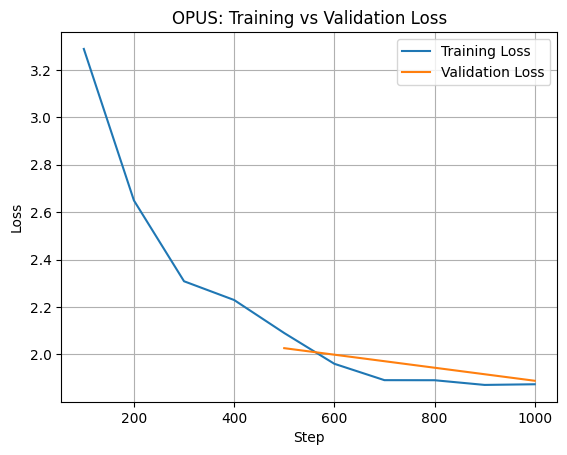

In [23]:
import matplotlib.pyplot as plt

# Training loss entries (they have 'loss' but no 'eval_loss')
train_loss_df = df_logs[df_logs["loss"].notna() & df_logs["step"].notna()][["step", "loss"]]

# Validation loss entries (they have 'eval_loss')
val_loss_df = df_logs[df_logs["eval_loss"].notna()][["step", "eval_loss"]]

plt.figure()
plt.plot(train_loss_df["step"], train_loss_df["loss"], label="Training Loss")
plt.plot(val_loss_df["step"], val_loss_df["eval_loss"], label="Validation Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("OPUS: Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


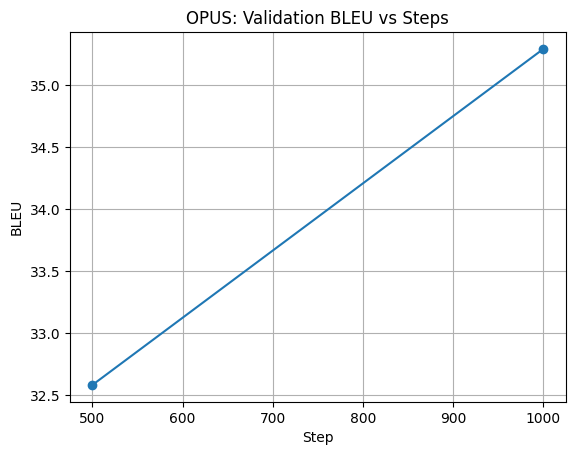

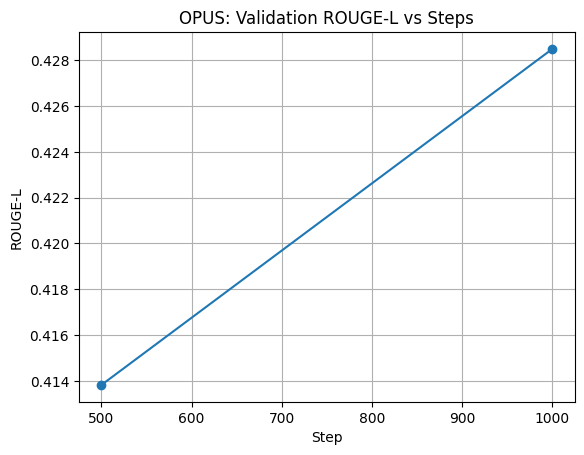

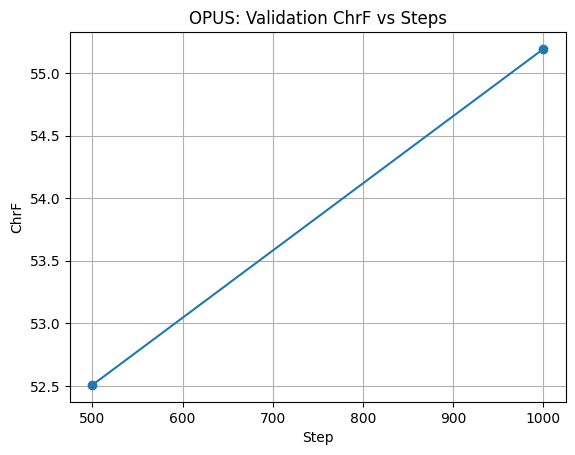

In [24]:
# Filter rows where eval metrics exist
metrics_df = df_logs[df_logs["eval_bleu"].notna()][["step", "eval_bleu", "eval_rougeL", "eval_chrf"]]

plt.figure()
plt.plot(metrics_df["step"], metrics_df["eval_bleu"], marker="o")
plt.xlabel("Step")
plt.ylabel("BLEU")
plt.title("OPUS: Validation BLEU vs Steps")
plt.grid(True)
plt.show()

plt.figure()
plt.plot(metrics_df["step"], metrics_df["eval_rougeL"], marker="o")
plt.xlabel("Step")
plt.ylabel("ROUGE-L")
plt.title("OPUS: Validation ROUGE-L vs Steps")
plt.grid(True)
plt.show()

plt.figure()
plt.plot(metrics_df["step"], metrics_df["eval_chrf"], marker="o")
plt.xlabel("Step")
plt.ylabel("ChrF")
plt.title("OPUS: Validation ChrF vs Steps")
plt.grid(True)
plt.show()
